In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
CMake Error at CMakeLists.txt:30 (add_subdirectory):
  add_subdirectory given source "pybind11" which is not an existing
  directory.


CMake Error at CMakeLists.txt:32 (pybind11_add_module):
  Unknown CMake command "pybind11_add_module".


-- Configuring incomplete, errors occurred!
See also "/home/juampi/facultad/metodos/entrega_tp3/buil

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import itertools
from tqdm import tqdm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [5]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/juampi/facultad/metodos/tp3_alu/notebooks
Python 3.6.9


In [6]:
df = pd.read_csv('../data/train.csv')

## Funciones

In [27]:
def crear_matriz_A(array, df):
    
    A = np.zeros(shape=(len(df),array.shape[0]))
    
    for index, elem in enumerate(array):
        col = df[elem].values.reshape(-1, 1)
    
        for i in range(len(df)):
             A[i,index] =float(col[i][0])
    return A

def limpiar(df, cat):
    res_df = df.copy()
    res_df.dropna(subset= cat, inplace=True)
    res_df.reset_index(drop=True, inplace=True)
    
    return res_df


def cross_val_log(df, K, fitting_cat):
    errores = []
    
    kf = KFold(K)
    contador = 0

    for train, test in kf.split(df):
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        A_train = crear_matriz_A(fitting_cat, train_df)
        y_train = train_df['precio']
        
        A_test = crear_matriz_A(fitting_cat, test_df)
        y_test = test_df['precio']

        regresor = metnum.LinearRegression()
        regresor.fit(A_train, y_train)
        pred = regresor.predict(A_test)
                        
        indices = np.where(pred >= 0)[0]
                  
        err = mean_squared_log_error(pred[indices], y_test[indices])
        
        errores.append(err)

    return errores



def cross_val(df, K, fitting_cat, testing_cat = []):
    errores = []
    
    kf = KFold(K)
    contador = 0

    for train, test in kf.split(df):
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        A_train = crear_matriz_A(fitting_cat, train_df)
        y_train = train_df['precio']
        
        A_test = crear_matriz_A(fitting_cat, test_df)
        y_test = test_df['precio']

        regresor = metnum.LinearRegression()
        regresor.fit(A_train, y_train)
        pred = regresor.predict(A_test)
        
        if testing_cat == []:
            err = mean_squared_error(pred, y_test)
            
        else:
            y_test = y_test.to_numpy()
            indices = []
            for i in range(len(test_df)):
                if hay_que_testear(test_df, i, testing_cat):
                    contador += 1
                    indices.append(i)
            
            pred = pred[indices]
            y_test = y_test[indices]
            err = mean_squared_error(pred, y_test)
        
        errores.append(err)
        
    if contador != 0:
        print(contador)
    return errores

def hay_que_testear(df, i, categories):
    for cat in categories:
        if test_df.iloc[i]['tipodepropiedad'] == cat:
            return True
    return False

def agregar_pbi(df):
    pbi_prov=np.array([21079,6199,9239,12502,16228,5890,8118,8011,6961,7235,11381,8833,12838,9449,11343,8044,4586,6508,5522,9347,7888,8108,9975,11060,6220,3592,9177,14364,5113,4446,51460,7600])
    
    df_copy = df.copy()
    
    df_copy.dropna(subset= ['provincia'], inplace=True)
    df_copy.reset_index(drop=True, inplace=True)
    
    df_prov = df_copy['provincia'].value_counts().rename_axis('provincia').reset_index(name='counts')
    del df_prov['counts']
    df_prov['PBI']=pd.Series(pbi_prov)
    df_prov.set_index('provincia', inplace=True)


    pbi_por_prov=np.array([], dtype=np.single)
    for i in range (len(df_copy)):
#     for i in tqdm (range (len(df_copy))):
        prov=df_copy.iloc[i]['provincia']
        pbi_por_prov=np.append(pbi_por_prov,float(df_prov.loc[prov]['PBI']))


    df_copy['PBI']=pd.Series(pbi_por_prov)
    
    return df_copy

def agregar_flia(df):
    
    df_copy = df.copy()
    
    df_copy.dropna(subset= ['banos', 'piscina', 'habitaciones', 'escuelascercanas'], inplace=True)
    df_copy.reset_index(drop=True, inplace=True)
    df_copy['bueno para familias'] = ((df_copy['banos']>1) & (df_copy['piscina']>0) & (df_copy['habitaciones']>2) & (df_copy['escuelascercanas']>0)).astype(int)
    
    return df_copy

def agregar_vacacional(df):
    df_copy = df.copy()
    
    filtro_provincias = (df_copy['provincia'] == 'Quintana Roo') | (df_copy['provincia'] == 'Campeche')
    filtro_ciudades = (df_copy['ciudad'] == 'Veracruz') | (df_copy['ciudad'] == 'Boca del Río') | (df_copy['ciudad'] == 'Alvarado') | (df_copy['ciudad'] == 'Los Cabos') | (df_copy['ciudad'] == 'La Paz') | (df_copy['ciudad'] == 'Puerto Vallarta') | (df_copy['ciudad'] == 'Mazatlán') | (df_copy['ciudad'] == 'Colima')

    df_copy['es_costero'] = (filtro_provincias | filtro_ciudades | (df_copy['piscina'] > 0)).astype(int)
    
    return df_copy

def segmentar_casas(df):
    df_copy = df.copy()
    filtro_casas = (df_copy['tipodepropiedad']  == 'Casa')
    
    df_copy = df_copy[filtro_casas]
    df_copy.reset_index(drop=True, inplace=True)
    
    return df_copy

def contar_apariciones(listas, categorias):
    apariciones = {}
    for cat in categorias:
        apariciones[cat] = 0
    
    for lista in listas:
        for elem in lista:
            apariciones[elem] += 1
    return apariciones

def find_region(provincia):
    regiones_dicc = {
        'noroeste': np.array(['Baja California Sur', 'Baja California Norte']),
       'pacifico' : np.array(['Sonora','Sinaloa']),
        'norte'   : np.array(['Chihuahua', 'Coahuila', 'Nuevo León', 'Tamaulipas', 'Durango']),
       'occidente': np.array(['Nayarit', 'Jalisco', 'Colima', 'Michoacán']),
       'distrito' : np.array(['Distrito Federal', 'Hidalgo', 'Edo. de México']),
        'bajio'   : np.array(['Aguascalientes', 'Guanajuato', 'Querétaro', 'San luis Potosí', 'Zacatecas']),
        'golfo'   : np.array(['Morelos', 'Oaxaca', 'Puebla', 'Veracruz', 'Tabasco', 'Tlaxcala', 'Guerrero']),
       'suroeste' : np.array(['Yucatán', 'Campeche', 'Quintana Roo', 'Chiapas'])
    }
    
    for key in regiones_dicc:
        if provincia in regiones_dicc[key]:
            return key

        
def agregar_region(_df):
    df = _df.copy()
    df['region'] = pd.Series(1)
    
    for i in tqdm(range(len(df))):
        provincia = df.iloc[i]['provincia']
        df.loc[i, 'region'] = find_region(provincia)
    
    return df


def sort_dicc(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

In [26]:
def cross_val_graph(df, K, fitting_cat1, fitting_cat2):
    pred1 = []
    pred2 = []
    reales = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        A_train1 = crear_matriz_A(fitting_cat1, train_df)       
        A_train2 = crear_matriz_A(fitting_cat2, train_df)
        y_train = train_df['precio']
        
        
        A_test1 = crear_matriz_A(fitting_cat1, test_df)
        A_test2 = crear_matriz_A(fitting_cat2, test_df)
        y_test = test_df['precio']

        regresor1 = metnum.LinearRegression()
        regresor1.fit(A_train1, y_train)
        _pred1 = regresor1.predict(A_test1)
        
        regresor2 = metnum.LinearRegression()
        regresor2.fit(A_train2, y_train)
        _pred2 = regresor2.predict(A_test2)

        
        indices = np.where((_pred1 >= 0) & (_pred1 >= 0))[0]
        
        
        pred1.append(_pred1[indices])
        pred2.append(_pred2[indices])
        reales.append(y_test[indices])
        
    return (pred1, pred2, reales)



def cross_val_provincias(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        print('Entre a kfold')
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for region in regiones:
            region_train_df = train_df[train_df['region'] == region]
            matrices_A_train[region] = crear_matriz_A(fitting_cat, region_train_df)
            y_trains[region] = region_train_df['precio']
            
            regresores[region] = metnum.LinearRegression()
            regresores[region].fit(matrices_A_train[region], y_trains[region])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            reg_test = dato_df['region'].to_numpy()[0]
            preds.append(regresores[reg_test].predict(A_test)[0,0])
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        err = mean_squared_error(preds, reales)
            
        errores.append(err)
        
    return errores


def cross_val_log_provincias(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        print('Entre a kfold')
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for region in regiones:
            region_train_df = train_df[train_df['region'] == region]
            matrices_A_train[region] = crear_matriz_A(fitting_cat, region_train_df)
            y_trains[region] = region_train_df['precio']
            
            regresores[region] = metnum.LinearRegression()
            regresores[region].fit(matrices_A_train[region], y_trains[region])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            reg_test = dato_df['region'].to_numpy()[0]
            preds.append(regresores[reg_test].predict(A_test)[0,0])
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        indices = np.where(preds >= 0)[0]
        
        err = mean_squared_log_error(preds[indices], reales[indices])
            
        errores.append(err)
        
    return errores

In [32]:
def agregar_propiedad(_df, region):
    losquesi = np.array(['Casa', 'Apartamento', 'Casa en condominio'])
    df = _df.copy()
    
    for i in tqdm(range(len(df))):
        if df.iloc[i]['region'] == region:  
            prop = df.iloc[i]['tipodepropiedad']
            if not (prop in losquesi):
                df.loc[i, 'tipodepropiedad'] = 'Otro'
            
    return df
    

def cross_val_propiedades(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        print('Entre a kfold')
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for propiedad in propiedades:
            propiedad_train_df = train_df[train_df['tipodepropiedad'] == propiedad]
            matrices_A_train[propiedad] = crear_matriz_A(fitting_cat, propiedad_train_df)
            y_trains[propiedad] = propiedad_train_df['precio']
            
            regresores[propiedad] = metnum.LinearRegression()
            regresores[propiedad].fit(matrices_A_train[propiedad], y_trains[propiedad])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            prop_test = dato_df['tipodepropiedad'].to_numpy()[0]
            preds.append(regresores[prop_test].predict(A_test)[0,0])
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        err = mean_squared_error(preds, reales)
            
        errores.append(err)
        
    return errores


def cross_val_log_propiedades(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        print('Entre a kfold')
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for propiedad in propiedades:
            propiedad_train_df = train_df[train_df['tipodepropiedad'] == propiedad]
            matrices_A_train[propiedad] = crear_matriz_A(fitting_cat, propiedad_train_df)
            y_trains[propiedad] = propiedad_train_df['precio']
            
            regresores[propiedad] = metnum.LinearRegression()
            regresores[propiedad].fit(matrices_A_train[propiedad], y_trains[propiedad])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            prop_test = dato_df['tipodepropiedad'].to_numpy()[0]
            preds.append(regresores[prop_test].predict(A_test)[0,0])
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        indices = np.where(preds >= 0)[0]
        
        err = mean_squared_log_error(preds[indices], reales[indices])
            
        errores.append(err)
        
    return errores

In [22]:
def cross_val_final(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for region in regiones:
            if region != 'distrito':
                region_train_df = train_df[train_df['region'] == region]
                matrices_A_train[region] = crear_matriz_A(fitting_cat, region_train_df)
                y_trains[region] = region_train_df['precio']

                regresores[region] = metnum.LinearRegression()
                regresores[region].fit(matrices_A_train[region], y_trains[region])
            else:
                regresores['distrito'] = {}
                matrices_A_train['distrito'] = {}
                y_trains['distrito'] = {}
                
                for propiedad in propiedades:
                    propiedad_train_df = train_df[(train_df['tipodepropiedad'] == propiedad) & (train_df['region'] == 'distrito')]
                    matrices_A_train['distrito'][propiedad] = crear_matriz_A(fitting_cat, propiedad_train_df)
                    y_trains['distrito'][propiedad] = propiedad_train_df['precio']

                    regresores['distrito'][propiedad] = metnum.LinearRegression()
                    regresores['distrito'][propiedad].fit(matrices_A_train['distrito'][propiedad], y_trains['distrito'][propiedad])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            reg_test = dato_df['region'].to_numpy()[0]
            if reg_test != 'distrito':
                preds.append(regresores[reg_test].predict(A_test)[0,0])
            else:
                prop_test = dato_df['tipodepropiedad'].to_numpy()[0]
                preds.append(regresores[reg_test][prop_test].predict(A_test)[0,0])
                
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        err = mean_squared_error(preds, reales)
            
        errores.append(err)
        
    return errores


def cross_val_log_final(df, K, fitting_cat):
        
    matrices_A_train = {}

    regresores = {}
    
    y_trains = {}
    
    errores = []
    
    kf = KFold(K)

    for train, test in kf.split(df):
        train_df = df.iloc[train].copy()
        test_df  = df.iloc[test].copy()

        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        
        for region in regiones:
            if region != 'distrito':
                region_train_df = train_df[train_df['region'] == region]
                matrices_A_train[region] = crear_matriz_A(fitting_cat, region_train_df)
                y_trains[region] = region_train_df['precio']

                regresores[region] = metnum.LinearRegression()
                regresores[region].fit(matrices_A_train[region], y_trains[region])
            else:
                regresores['distrito'] = {}
                matrices_A_train['distrito'] = {}
                y_trains['distrito'] = {}
                
                for propiedad in propiedades:
                    propiedad_train_df = train_df[(train_df['tipodepropiedad'] == propiedad) & (train_df['region'] == 'distrito')]
                    matrices_A_train['distrito'][propiedad] = crear_matriz_A(fitting_cat, propiedad_train_df)
                    y_trains['distrito'][propiedad] = propiedad_train_df['precio']

                    regresores['distrito'][propiedad] = metnum.LinearRegression()
                    regresores['distrito'][propiedad].fit(matrices_A_train['distrito'][propiedad], y_trains['distrito'][propiedad])
            
            
        preds = []
        reales = []
        
        for i in range(len(test_df)):
            dato_df = test_df[test_df.index == i]
            A_test = crear_matriz_A(fitting_cat, dato_df)
            y_test = dato_df['precio']
            reg_test = dato_df['region'].to_numpy()[0]
            if reg_test != 'distrito':
                preds.append(regresores[reg_test].predict(A_test)[0,0])
            else:
                prop_test = dato_df['tipodepropiedad'].to_numpy()[0]
                preds.append(regresores[reg_test][prop_test].predict(A_test)[0,0])
                
            reales.append(float(y_test))

        preds = np.array(preds)
        reales = np.array(reales)
        
        indices = np.where(preds >= 0)[0]
        
        err = mean_squared_log_error(preds[indices], reales[indices])
           
        errores.append(err)
        
    return errores

In [36]:
cat_11 = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])
cat_simples = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio'])
cat_pbi = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio', 'PBI'])

propiedades = np.array(['Casa','Apartamento', 'Casa en condominio', 'Otro']) 
regiones = np.array(['noroeste','pacifico','norte','occidente','distrito','bajio','golfo','suroeste'])

### Experimento 1

#### Hiperplano basico

In [369]:
cat_todos = df.columns

categorias1 = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])
df1 = limpiar(df, cat_todos)
print(f'El dataset quedo con: {len(df1)}')
errores = cross_val(df1, 5, categorias1)
print(f'Todas las categorias:')
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


categorias1 = np.array(['metroscubiertos'])
df1 = limpiar(df, cat_todos)
print(f'\n\nEl dataset quedo con: {len(df1)}')
errores = cross_val(df1, 5, categorias1)
print(f'Solo metros cubiertos:')
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


categorias1 = np.array(['usosmultiples', 'piscina', 'escuelascercanas','centroscomercialescercanos'])
df1 = limpiar(df, cat_todos)
print(f'\n\nEl dataset quedo con: {len(df1)}')
errores = cross_val(df1, 5, categorias1)
print(f'Solo cosas malas:')
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


categorias1 = np.array(['metroscubiertos','habitaciones'])
df1 = limpiar(df, cat_todos)
print(f'\n\nEl dataset quedo con: {len(df1)}')
errores = cross_val(df1, 5, categorias1)
print(f'Metros cubiertos y habitaciones (2 buenas categorias):')
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

El dataset quedo con: 49881
Todas las categorias:
std: 3.80e+10 mean: 1.70e+12


El dataset quedo con: 49881
Solo metros cubiertos:
std: 5.04e+10 mean: 2.05e+12


El dataset quedo con: 49881
Solo cosas malas:
std: 1.04e+11 mean: 4.49e+12


El dataset quedo con: 49881
2 cosas buenas:
std: 4.92e+10 mean: 2.05e+12


### Experimento 2

#### Todas las combinaciones posibles

In [120]:
iterable = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])

df_exp2 = limpiar(df, iterable)

N_exp2 = len(df_exp2)
N_train2 = round(N_exp2 * 0.8)

exp2_train = df_exp2[:N_train2].copy()
exp2_val   = df_exp2[N_train2:].copy()

exp2_train.reset_index(drop=True, inplace=True)
exp2_val.reset_index(drop=True, inplace=True)

y_exp2_train = exp2_train['precio']
y_exp2_val = exp2_val['precio']

regresor_exp2 = metnum.LinearRegression()


combinaciones = []
for r in range(1, len(iterable)):
    combinaciones.append(list(itertools.combinations(iterable, r)))

    
winner_error_exp2 = -1
winner_list_exp2 = []
errores_exp2 = []
listas_exp2 = []
for combinacion in tqdm(combinaciones):
    for tupla in combinacion:
        if len(tupla) <= 4:
            A_exp2_train = crear_matriz_A(np.array(tupla), exp2_train)
            regresor_exp2.fit(A_exp2_train, y_exp2_train)

            A_exp2_val = crear_matriz_A(np.array(tupla), exp2_val)
            pred_exp2 = regresor_exp2.predict(A_exp2_val)

            current_error = mean_squared_error(pred_exp2, y_exp2_val)

            errores_exp2.append(current_error)
            listas_exp2.append(tupla)
            if(winner_error_exp2 == -1 or winner_error_exp2 > current_error):
                winner_error_exp2 = current_error
                winner_list_exp2 = list(tupla)


indices_exp2 = np.argsort(errores_exp2)
sorted_errores_exp2 = np.array(errores_exp2)[indices_exp2]
sorted_lists_exp2 = np.array(listas_exp2)[indices_exp2]

for e, l in zip(sorted_errores_exp2, sorted_lists_exp2):
    print(f'Lista: {l}, Error: {e}')

100%|██████████| 10/10 [01:45<00:00, 10.59s/it]

Lista: ('metroscubiertos', 'banos', 'habitaciones', 'gimnasio'), Error: 1634109881718.4014
Lista: ('metroscubiertos', 'habitaciones', 'garages', 'gimnasio'), Error: 1638560857364.984
Lista: ('metroscubiertos', 'banos', 'habitaciones', 'garages'), Error: 1668855341963.0317
Lista: ('metrostotales', 'metroscubiertos', 'habitaciones', 'gimnasio'), Error: 1669484583654.7207
Lista: ('metrostotales', 'metroscubiertos', 'garages', 'gimnasio'), Error: 1676233499967.1348
Lista: ('metrostotales', 'metroscubiertos', 'banos', 'gimnasio'), Error: 1677160834965.2397
Lista: ('metroscubiertos', 'garages', 'gimnasio', 'usosmultiples'), Error: 1678858391604.0427
Lista: ('metroscubiertos', 'banos', 'garages', 'gimnasio'), Error: 1679440620521.0642
Lista: ('metrostotales', 'metroscubiertos', 'gimnasio', 'usosmultiples'), Error: 1680870120855.3855
Lista: ('metroscubiertos', 'banos', 'habitaciones', 'usosmultiples'), Error: 1681518089572.3376
Lista: ('metroscubiertos', 'banos', 'gimnasio', 'usosmultiples'), 

In [312]:
cat_simples = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio'])
df_simples = limpiar(df, cat_11)
errores = cross_val(df_simples, 5, cat_11)
print(f'El dataset quedo con: {len(df_simples)}')
print(f'Todas las categorias numericas:')
print(cat_simples)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


iterable = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])
dicc_apariciones = contar_apariciones(sorted_lists_exp2[:50], iterable)

print('\n\nApariciones de cada caracteristica en las 50 mejores combinaciones')
dicc_apariciones = sort_dicc(dicc_apariciones)
for key in dicc_apariciones:
    print(f'{key}: {dicc_apariciones[key]}')

El dataset quedo con: 120510
Mejor combinacion 4 categorias:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio']
std: 2.09e+10 mean: 1.52e+12


Apariciones de cada caracteristica en las 50 mejores combinaciones
escuelascercanas: 6
antiguedad: 8
piscina: 9
metrostotales: 11
usosmultiples: 11
centroscomercialescercanos: 11
garages: 14
banos: 15
habitaciones: 19
gimnasio: 40
metroscubiertos: 50


In [316]:
cat_simples = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio'])
df_simples = limpiar(df, cat_11)
errores = cross_val(df_simples, 5, cat_simples)
print(f'El dataset quedo con: {len(df_simples)}')
print(f'Mejor combinacion 4 categorias:')
print(cat_simples)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


iterable = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])
dicc_apariciones = contar_apariciones(sorted_lists_exp2[:50], iterable)

print('\n\nApariciones de cada caracteristica en las 50 mejores combinaciones')
dicc_apariciones = sort_dicc(dicc_apariciones)
for key in dicc_apariciones:
    print(f'{key}: {dicc_apariciones[key]}')

El dataset quedo con: 120510
Mejor combinacion 4 categorias:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio']
std: 1.99e+10 mean: 1.62e+12


Apariciones de cada caracteristica en las 50 mejores combinaciones
escuelascercanas: 6
antiguedad: 8
piscina: 9
metrostotales: 11
usosmultiples: 11
centroscomercialescercanos: 11
garages: 14
banos: 15
habitaciones: 19
gimnasio: 40
metroscubiertos: 50


##### Error logaritmico

In [360]:
errores = cross_val_log(df_simples, 5, cat_simples)
print(f'El dataset quedo con: {len(df_simples)}')
print(f'Mejor combinacion 4 categorias (logaritmico):')
print(cat_simples)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

id                                                                       152526
titulo                        casa en buenas condiciones en valle de  jacara...
descripcion                   casa de 1 nivel con: cochera 1 auto, sala, com...
tipodepropiedad                                                            Casa
direccion                                                              CORREOS 
ciudad                                                          San Luis Potosí
provincia                                                       San luis Potosí
antiguedad                                                                   10
habitaciones                                                                 10
garages                                                                       1
banos                                                                         1
metroscubiertos                                                              90
metrostotales                           

In [358]:
cat_11 = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos', 'antiguedad'])
df_log2 = limpiar(df, cat_11)

errores = cross_val(df_log2, 5, cat_11)
print(f'\n\nEl dataset quedo con: {len(df_log2)}')
print(f'11 categorias:')
print(cat_11)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


errores = cross_val_log(df_log2, 5, cat_11)
print(f'El dataset quedo con: {len(df_log2)}')
print(f'11 categorias (logaritmico):')
print(cat_11)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

El dataset quedo con: 120510
11 categorias:
['metrostotales' 'metroscubiertos' 'banos' 'habitaciones' 'garages'
 'gimnasio' 'usosmultiples' 'piscina' 'escuelascercanas'
 'centroscomercialescercanos' 'antiguedad']
std: 0.0034897377554553425 mean: 0.2898396248411463


El dataset quedo con: 120510
11 categorias:
['metrostotales' 'metroscubiertos' 'banos' 'habitaciones' 'garages'
 'gimnasio' 'usosmultiples' 'piscina' 'escuelascercanas'
 'centroscomercialescercanos' 'antiguedad']
std: 2.09e+10 mean: 1.52e+12


### Experimento 3

#### Feature engineering: PBI

In [429]:
cat_base = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos'])
cat_pbi = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio', 'PBI'])
df_pbi = limpiar(df, cat_11)
df_pbi = agregar_pbi(df_pbi)

errores = cross_val(df_pbi, 5, cat_pbi)

print(f'Mejor combinacion 4 categorias, agregamos PBI:')
print(f'El dataset quedo con: {len(df_pbi)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

errores = cross_val_log(df_pbi, 5, cat_pbi)

print(f'Mejor combinacion 4 categorias, agregamos PBI (logaritmico):')
print(f'El dataset quedo con: {len(df_pbi)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

Dataset completo, agregamos PBI:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 1.90e+10 mean: 1.43e+12
Dataset completo, agregamos PBI:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 0.0019484757694621048 mean: 0.29088205047241755


### Experimento 4

#### Feature engineering: Bueno para la familia

In [449]:
cat_base = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos'])
cat_flia = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio', 'PBI', 'bueno para familias'])
df_flia = limpiar(df, cat_11)
df_flia = agregar_pbi(df_flia)
df_flia = agregar_flia(df_flia)


errores = cross_val(df_flia, 5, cat_flia)

print(f'Mejor combinacion 4 categorias, agregamos PBI y FLIA:')
print(f'El dataset quedo con: {len(df_flia)}')
print(f'Entrenando con las 4 mejores + PBI + FLIA:')
print(cat_flia)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


errores = cross_val_log(df_flia, 5, cat_flia)

print(f'Mejor combinacion 4 categorias, agregamos PBI y FLIA (logaritmico):')
print(f'El dataset quedo con: {len(df_flia)}')
print(f'Entrenando con las 4 mejores + PBI + FLIA:')
print(cat_flia)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

Dataset completo, agregamos FLIA:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI + FLIA:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI'
 'bueno para familias']
std: 1.90e+10 mean: 1.43e+12
Dataset completo, agregamos FLIA:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI + FLIA:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI'
 'bueno para familias']
std: 0.003620154610271591 mean: 0.29050448449039157


### Experimento 5

#### Feature engineering: Vacacional

In [459]:
cat_base = np.array(['metrostotales','metroscubiertos','banos','habitaciones','garages','gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos'])
cat_vacacional = np.array(['metroscubiertos', 'banos', 'habitaciones', 'gimnasio', 'PBI', 'bueno para familias', 'es_costero'])
df_vacacional = limpiar(df, cat_11)
df_vacacional = agregar_pbi(df_vacacional)
df_vacacional = agregar_flia(df_vacacional)
df_vacacional = agregar_vacacional(df_vacacional)


errores = cross_val(df_vacacional, 5, cat_vacacional)

print(f'Mejor combinacion 4 categorias, agregamos PBI, FLIA y VACACIONAL:')
print(f'El dataset quedo con: {len(df_vacacional)}')
print(f'Entrenando con las 4 mejores + PBI + FLIA + VACACIONAL:')
print(cat_vacacional)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


errores = cross_val_log(df_vacacional, 5, cat_vacacional)

print(f'\n\nMejor combinacion 4 categorias, agregamos PBI, FLIA y VACACIONAL (logaritmico):')
print(f'El dataset quedo con: {len(df_vacacional)}')
print(f'Entrenando con las 4 mejores + PBI + FLIA + VACACIONAL:')
print(cat_vacacional)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

Dataset completo, agregamos COSTA:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI + FLIA + COSTA:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI'
 'bueno para familias' 'es_costero']
std: 1.91e+10 mean: 1.43e+12


Dataset completo, agregamos COSTA:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI + FLIA + COSTA:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI'
 'bueno para familias' 'es_costero']
std: 0.0019942488103836396 mean: 0.29053322349601196


### Experimento 6

#### Segmentar por regiones

##### Separamos por regiones

In [587]:
regiones = np.array(['noroeste','pacifico','norte','occidente','distrito','bajio','golfo','suroeste'])

noroeste = np.array(['Baja California Sur', 'Baja California Norte'])
pacifico = np.array(['Sonora','Sinaloa'])
norte    = np.array(['Chihuahua', 'Coahuila', 'Nuevo León', 'Tamaulipas', 'Durango'])
occidente= np.array(['Nayarit', 'Jalisco', 'Colima', 'Michoacán'])
distrito = np.array(['Distrito Federal', 'Hidalgo', 'Edo. de México'])
bajio    = np.array(['Aguascalientes', 'Guanajuato', 'Querétaro', 'San luis Potosí', 'Zacatecas'])
golfo    = np.array(['Morelos', 'Oaxaca', 'Puebla', 'Veracruz', 'Tabasco', 'Tlaxcala', 'Guerrero'])
suroeste = np.array(['Yucatán', 'Campeche', 'Quintana Roo', 'Chiapas'])

In [28]:
df_seg_prov = limpiar(df, cat_11)
df_seg_prov = agregar_pbi(df_seg_prov)
df_seg_prov = agregar_region(df_seg_prov)

100%|██████████| 120502/120502 [03:36<00:00, 556.33it/s]


##### Calculamos el error por region


In [588]:
errores_cuad = {}
errores_log = {}

for region in regiones:
    df_region = df_seg_prov[df_seg_prov['region'] == region].copy()
    errores = cross_val(df_region, 5, cat_pbi)
    errores_cuad[region] = np.mean(errores)
    errores = cross_val_log(df_region, 5, cat_pbi)
    errores_log[region] = np.mean(errores)
    
errores_cuad = sort_dicc(errores_cuad)
errores_log = sort_dicc(errores_log)

for key in errores_cuad:
    print(f'{key}: {errores_cuad[key]:.2e}')
    
print('\n\n')
for key in errores_log:
    print(f'{key}: {errores_log[key]:.4}')

noroeste: 1.37e+11
bajio: 3.63e+11
pacifico: 3.92e+11
golfo: 6.43e+11
occidente: 7.57e+11
suroeste: 7.74e+11
norte: 8.93e+11
distrito: 1.95e+12



bajio: 0.1048
noroeste: 0.1171
golfo: 0.1486
suroeste: 0.1706
pacifico: 0.1903
occidente: 0.1935
distrito: 0.2922
norte: 0.2967


##### Ahora el error total, pero con los regresores segmentados

In [589]:
errores = cross_val_provincias(df_seg_prov, 5, cat_pbi)

print(f'Dataset segmentado por region:')
print(f'El dataset quedo con: {len(df_seg_prov)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

errores = cross_val_log_provincias(df_seg_prov, 5, cat_pbi)

print(f'\n\nDataset segmentado region (logaritmico):')
print(f'El dataset quedo con: {len(df_seg_prov)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

  0%|          | 33/120502 [00:00<06:06, 329.09it/s]

Listo el PBI


100%|██████████| 120502/120502 [03:47<00:00, 530.64it/s]
0it [00:00, ?it/s]

Lista la region
Entre a kfold


1it [00:19, 19.23s/it]

Entre a kfold


2it [00:39, 19.50s/it]

Entre a kfold


3it [00:57, 18.95s/it]

Entre a kfold


4it [01:15, 18.94s/it]

Entre a kfold


5it [01:36, 19.23s/it]


Dataset segmentado (todo menos df):
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 1.46e+10 mean: 1.20e+12
Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold


Dataset segmentado log (todo menos df):
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 0.0039697312891777805 mean: 0.22782834397039387


### Experimento 7

#### Segmentar por propiedad en region distrito

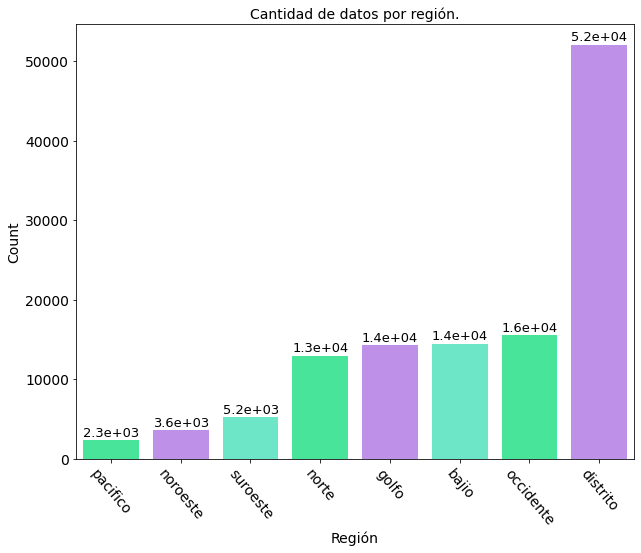

In [75]:
ax, fig = plt.subplots(figsize=(10,8))
colores=['#2EFE9A', '#BE81F7','#58FAD0']

y = np.flip(df_seg_prov['region'].value_counts().to_numpy())
x = np.arange(len(y))
sns.countplot(data=df_seg_prov, x='region', order = np.flip(df_seg_prov['region'].value_counts().index.to_numpy()), palette=colores)
plt.xticks(rotation=310, fontsize=14)
plt.xlabel('Región',fontsize=14)

plt.yticks(fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Cantidad de datos por región.', fontsize=14)

for i in range(len(y)):
    plt.text(x = x[i]-0.4 , y = y[i]+5e2, s = "{:.1e}".format(y[i]), size = 13)


plt.savefig('imagenes/countplot_regiones.png')
plt.show()

In [33]:
df_distrito = df_seg_prov[df_seg_prov['region'] == 'distrito'].copy()
df_distrito.reset_index(drop=True, inplace=True)
df_distrito = agregar_propiedad(df_distrito, 'distrito')

100%|██████████| 52023/52023 [00:15<00:00, 3367.02it/s]


In [37]:
errores = cross_val_propiedades(df_distrito, 5, cat_pbi)

print(f'Dataset segmentado por propiedad:')
print(f'El dataset quedo con: {len(df_distrito)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

errores = cross_val_log_propiedades(df_distrito, 5, cat_pbi)

print(f'\n\nDataset segmentado por propiedad (logaritmico):')
print(f'El dataset quedo con: {len(df_distrito)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')


Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold
Dataset segmentado (todo menos df):
El dataset quedo con: 52023
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 2.60e+10 mean: 1.62e+12
Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold
Entre a kfold


Dataset segmentado log (todo menos df):
El dataset quedo con: 52023
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 0.0025077893050851853 mean: 0.23838864731008563


##### Calculamos el error por propiedad

In [41]:
errores_cuad = {}
errores_log = {}

for propiedad in propiedades:
    df_propiedad = df_distrito[df_distrito['tipodepropiedad'] == propiedad].copy()
    errores = cross_val(df_propiedad, 5, cat_pbi)
    errores_cuad[propiedad] = np.mean(errores)
    errores = cross_val_log(df_propiedad, 5, cat_pbi)
    errores_log[propiedad] = np.mean(errores)
    
errores_cuad = sort_dicc(errores_cuad)
errores_log = sort_dicc(errores_log)

for key in errores_cuad:
    print(f'{key}: {errores_cuad[key]:.2e}')
    
print('\n\n')
for key in errores_log:
    print(f'{key}: {errores_log[key]:.4}')

Casa en condominio: 1.57e+12
Casa: 1.57e+12
Apartamento: 1.67e+12
Otro: 2.73e+12



Casa en condominio: 0.183
Casa: 0.2329
Apartamento: 0.2653
Otro: 0.3861


### Ahora metemos esa segmentacion en el dataset completo

In [627]:
df_final = df_seg_prov.copy()
df_final = agregar_propiedad(df_final, 'distrito')

100%|██████████| 120502/120502 [00:33<00:00, 3550.92it/s]


In [645]:
errores = cross_val_final(df_final, 5, cat_pbi)

print(f'Dataset segmentado por regiones y distrito por propiedad:')
print(f'El dataset quedo con: {len(df_final)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

errores = cross_val_log_final(df_final, 5, cat_pbi)

print(f'\n\nDataset segmentado por regiones y distrito por propiedad (logaritmico):')
print(f'El dataset quedo con: {len(df_final)}')
print(f'Entrenando con las 4 mejores + PBI:')
print(cat_pbi)
print(f'std: {np.sqrt(np.std(errores))} mean: {np.sqrt(np.mean(errores))}')

Dataset segmentado por regiones y distrito por propiedad:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 1.27e+10 mean: 1.06e+12


Dataset segmentado por regiones y distrito por propiedad:
El dataset quedo con: 120502
Entrenando con las 4 mejores + PBI:
['metroscubiertos' 'banos' 'habitaciones' 'gimnasio' 'PBI']
std: 0.003970380236700162 mean: 0.20486337581590877
